## Baltimore Crime Data
Location, categorical, and time data are given to predict what type of crime will occur over the Baltimore area. Many features are provided for the prediction, but only the ones that would be known *before* a crime is committed are used for the prediction. The value of this data and model would be to better prepare law enforcement for the type of crime that is likely to occur based on their location and time. The features used are:
1. Time and Date
2. Location (latitude & longitude)
3. Neighborhood
4. District
5. Post


There are 14 different crime types reported in the data. To improve model accuracy, crimes were grouped into 4 categories:

1. Altercations involving deadly or violent force (Assault, shooting, homicide, robbery, burglary)

2. Non-violent crimes (Theft, larceny)

3. Rape

4. Arson

In [1]:
#Import libraries in

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [2]:
crime_data = pd.read_csv('Part1_Crime_data.csv')

In [3]:
#Start to explore data
crime_data.head()

,X,Y,RowID,CrimeDateTime,CrimeCode,Location,Description,Inside_Outside,Weapon,Post,District,Neighborhood,Latitude,Longitude,GeoLocation,Premise,VRIName,Total_Incidents,Shape
0,1421661.420,593584.4920,1,2021/09/24 08:00:00+00,6D,500 SAINT PAUL ST APT 118,LARCENY FROM AUTO,NaN,NaN,124,CENTRAL,MOUNT VERNON,39.2959,-76.6137,"(39.2959,-76.6137)",NaN,NaN,1,NaN
1,1428629.529,592267.2422,2,2021/09/23 02:00:00+00,6D,0 N WASHINGTON ST,LARCENY FROM AUTO,NaN,NaN,212,SOUTHEAST,BUTCHER'S HILL,39.2922,-76.5891,"(39.2922,-76.5891)",NaN,NaN,1,NaN
2,1429981.578,593693.8871,3,2021/09/23 09:00:00+00,6J,400 N BRADFORD ST,LARCENY,NaN,NaN,221,SOUTHEAST,MCELDERRY PARK,39.2961,-76.5843,"(39.2961,-76.5843)",NaN,NaN,1,NaN
3,1433589.463,590796.6733,4,2021/09/23 18:27:00+00,6J,300 S EAST AVE,LARCENY,NaN,NaN,225,SOUTHEAST,HIGHLANDTOWN,39.2881,-76.5716,"(39.2881,-76.5716)",NaN,NaN,1,NaN
4,1421304.259,591033.3302,5,2021/09/23 23:00:00+00,6D,0 S CHARLES ST,LARCENY FROM AUTO,NaN,NaN,114,CENTRAL,DOWNTOWN,39.2889,-76.6150,"(39.2889,-76.615)",NaN,NaN,1,NaN


In [4]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350294 entries, 0 to 350293
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                350087 non-null  float64
 1   Y                350087 non-null  float64
 2   RowID            350294 non-null  int64  
 3   CrimeDateTime    350270 non-null  object 
 4   CrimeCode        350294 non-null  object 
 5   Location         348499 non-null  object 
 6   Description      350294 non-null  object 
 7   Inside_Outside   302508 non-null  object 
 8   Weapon           76056 non-null   object 
 9   Post             349552 non-null  object 
 10  District         349552 non-null  object 
 11  Neighborhood     349530 non-null  object 
 12  Latitude         350087 non-null  float64
 13  Longitude        350087 non-null  float64
 14  GeoLocation      350294 non-null  object 
 15  Premise          302370 non-null  object 
 16  VRIName          41597 non-null   obje

In [5]:
#X, Y, RowID, CrimeCode, Inside_Outside, Weapon, GeoLocation, Total_Incidents, and Shape are not needed for model, will be dropped.
#VRIName name has some valuable location data, but has many missing values. It is only about 11.8% of the data. We can drop this column as well.
crime_data['VRIName'].value_counts()

Tri-District    7916
Western         7200
Central         6520
Eastern 1       5390
Eastern 2       4076
Northwestern    3972
Northeastern    3518
Brooklyn        3005
Name: VRIName, dtype: int64

In [6]:
#Some of the data has very low counts in certain categories, for example, the Neighborhood column
crime_data['Neighborhood'].value_counts()

DOWNTOWN                   11760
FRANKFORD                   8291
BELAIR-EDISON               7473
BROOKLYN                    6354
SANDTOWN-WINCHESTER         5118
                           ...  
TAYLOR HEIGHTS                49
GREENMOUNT CEMETERY           40
MT PLEASANT PARK              21
BLYTHEWOOD                     7
DUNDALK MARINE TERMINAL        5
Name: Neighborhood, Length: 278, dtype: int64

In [7]:
#Drop rows that contain categories for 'Neighborhood' that are very low in count so that model can learn properly
neighborhood = crime_data['Neighborhood'].value_counts().keys().tolist()
n_counts = crime_data['Neighborhood'].value_counts().tolist()

for (neighborhood, count) in zip(neighborhood, n_counts):
    if count < 100:
        idxs = crime_data[crime_data['Neighborhood'] == neighborhood].index
        crime_data.drop(idxs, inplace=True)

In [8]:
#Drop all unnecessary columns, and drop rows with missing values (relatively low amount of rows)

crime_data_df = crime_data.drop(labels = ['RowID', 'X', 'Y', 'Weapon', 'VRIName', 'Shape', 'Total_Incidents', 'CrimeCode', 'GeoLocation', 'Location', 'Inside_Outside', 'Premise', 'Post', 'District', 'Neighborhood'], axis = 1)
crime_data_df.dropna(inplace = True)
crime_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349194 entries, 0 to 350293
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   CrimeDateTime  349194 non-null  object 
 1   Description    349194 non-null  object 
 2   Latitude       349194 non-null  float64
 3   Longitude      349194 non-null  float64
dtypes: float64(2), object(2)
memory usage: 13.3+ MB


<AxesSubplot:xlabel='Description', ylabel='count'>

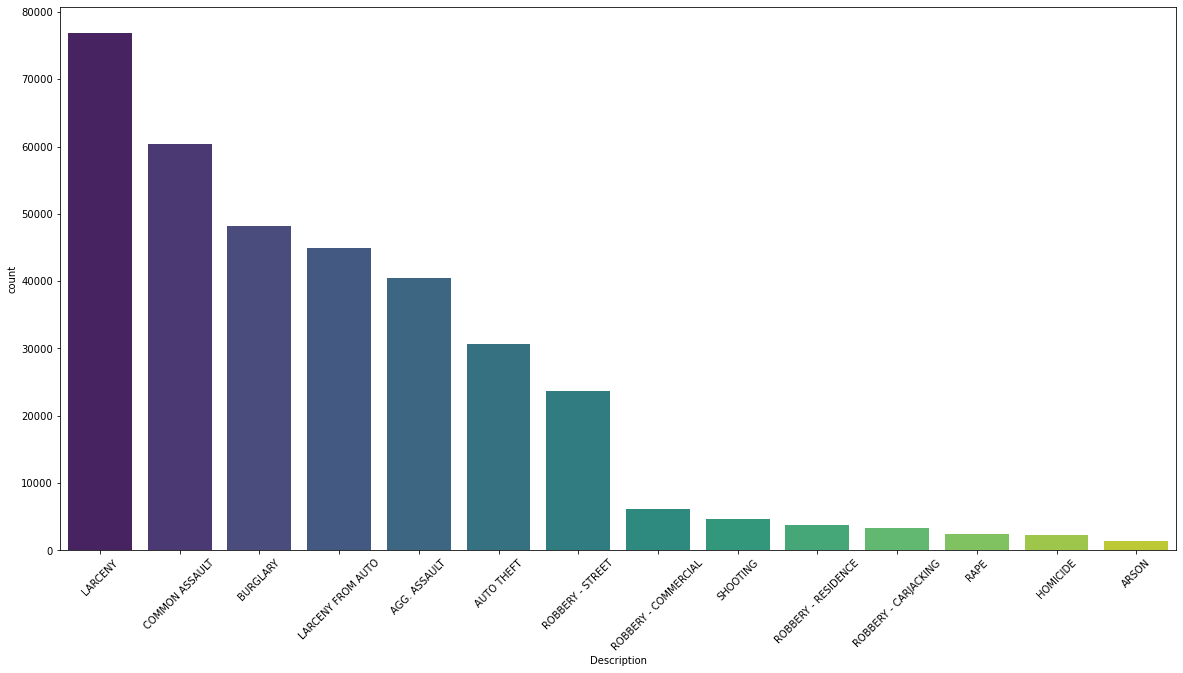

In [9]:
#Explore crime type count. Note that data is quite unbalanced.

plt.figure(figsize = (20,10))
plt.xticks(rotation=45)
sns.countplot(x='Description', data = crime_data, palette = 'viridis', order = crime_data_df['Description'].value_counts().index)

ValueError: Contour levels must be increasing

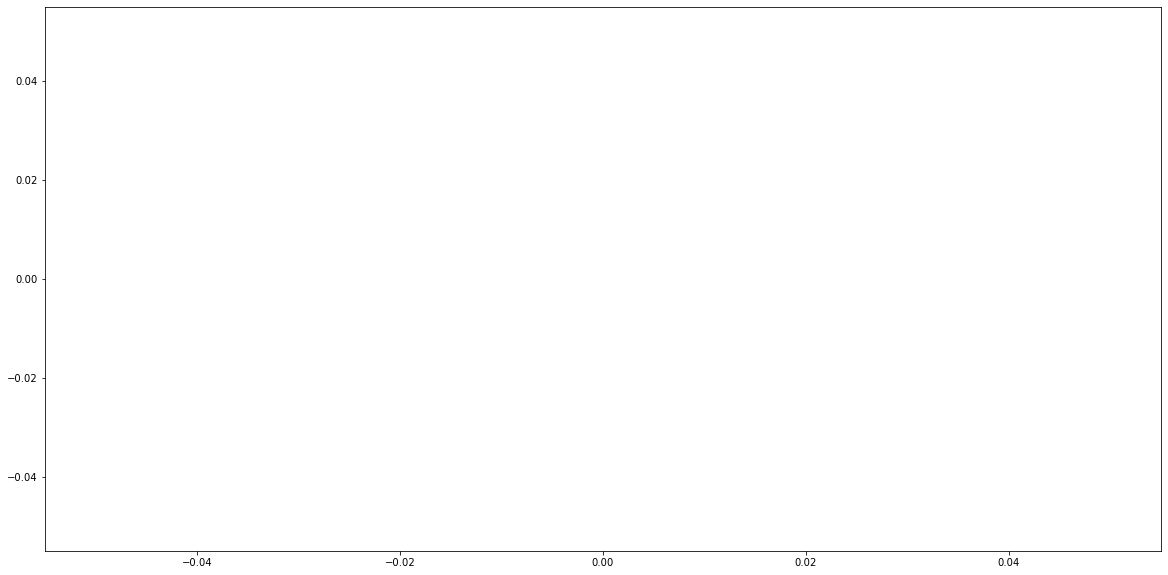

In [10]:
plt.figure(figsize = (20,10))
sns.kdeplot(x = crime_data_df['Latitude'], y = crime_data_df['Longitude'], cmap="plasma", 
            shade=True)


In [ ]:
#Must convert 'CrimeDateTime' column into useable format
type(crime_data_df['CrimeDateTime'].iloc[0])

In [11]:
crime_data_df['CrimeDateTime'] = pd.to_datetime(crime_data_df['CrimeDateTime'])

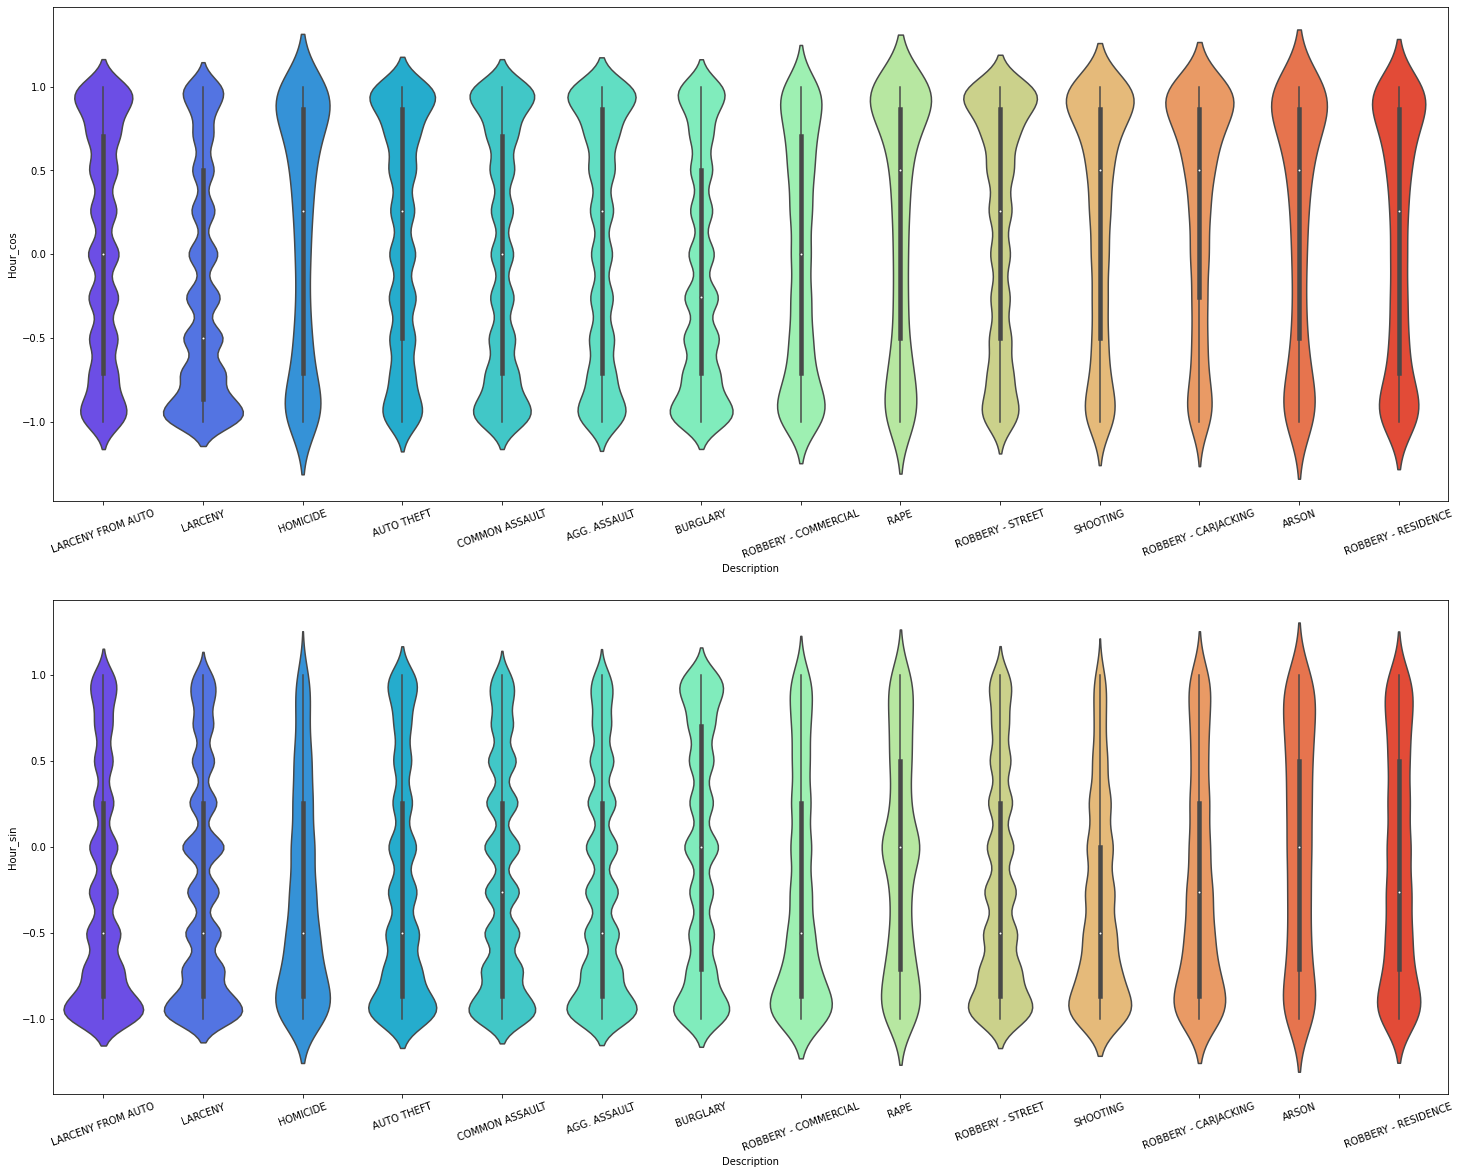

In [12]:
#Take out hour, month, and day of the week from CrimeDateTime, convert to cyclical variable through sin & cos
Hour = crime_data_df['CrimeDateTime'].apply(lambda t: t.hour)
crime_data_df['Hour_cos'] = Hour.apply(lambda x: np.cos((2*np.pi*x)/24))
crime_data_df['Hour_sin'] = Hour.apply(lambda x: np.sin((2*np.pi*x)/24))

Month =crime_data_df['CrimeDateTime'].apply(lambda t: t.month)
crime_data_df['Month_cos'] = Month.apply(lambda x: np.cos((2*np.pi*x)/12))
crime_data_df['Month_sin'] = Month.apply(lambda x: np.sin((2*np.pi*x)/12))

Day =crime_data_df['CrimeDateTime'].apply(lambda t: t.dayofweek)
crime_data_df['Day_cos'] = Day.apply(lambda x: np.cos((2*np.pi*x)/7))
crime_data_df['Day_sin'] = Day.apply(lambda x: np.cos((2*np.pi*x)/7))

#Explore data through violin plots. Hour of the day helps distinguish crime type.
fig = plt.figure(figsize = (25,20))

for i in range(1, 3):
    axes = fig.add_subplot(2, 1, i)
    plt.xticks(rotation=20)
    if(i == 1):
        sns.violinplot(x='Description', y='Hour_cos', data= crime_data_df ,palette='rainbow')
    else:
        sns.violinplot(x='Description', y='Hour_sin', data= crime_data_df ,palette='rainbow')

In [ ]:
#Month helps distinguish crime type for some crimes
fig = plt.figure(figsize = (25,20))

for i in range(1, 3):
    axes = fig.add_subplot(2, 1, i)
    plt.xticks(rotation=20)
    if(i == 1):
        sns.violinplot(x='Description', y='Month_cos', data= crime_data_df ,palette='rainbow')
    else:
        sns.violinplot(x='Description', y='Month_sin', data= crime_data_df ,palette='rainbow')

In [ ]:
#Day of the week helps distinguish crime type for some crimes
fig = plt.figure(figsize = (25,20))

for i in range(1, 3):
    axes = fig.add_subplot(2, 1, i)
    plt.xticks(rotation=20)
    if(i == 1):
        sns.violinplot(x='Description', y='Day_cos', data= crime_data_df ,palette='rainbow')
    else:
        sns.violinplot(x='Description', y='Day_sin', data= crime_data_df ,palette='rainbow')

In [ ]:
#List out crime types from Description column. To increase model accuracy group like crimes together.
crime_data_df['Description'].unique()

In [13]:
#Group crimes together by similar type into 4 types
crime_data_df['Crime'] = crime_data_df['Description'].map({'ROBBERY - RESIDENCE': 0, 'HOMICIDE': 0, 'LARCENY': 2, 'AUTO THEFT': 2, 'COMMON ASSAULT': 0,
                                                          'LARCENY FROM AUTO': 2, 'AGG. ASSAULT': 0, 'BURGLARY': 0,
                                                          'ROBBERY - COMMERCIAL': 0, 'RAPE': 1, 'ROBBERY - STREET': 0, 'SHOOTING': 0,
                                                           'ROBBERY - CARJACKING': 0, 'ARSON': 3})

#Now drop unnecessary columns
crime_data_df.drop(['CrimeDateTime', 'Description'], axis = 1, inplace = True)
crime_data_df.head()

,Latitude,Longitude,Hour_cos,Hour_sin,Month_cos,Month_sin,Day_cos,Day_sin,Crime
0,39.2959,-76.6137,-5.000000e-01,0.866025,-1.836970e-16,-1.0,-0.900969,-0.900969,2
1,39.2922,-76.5891,8.660254e-01,0.500000,-1.836970e-16,-1.0,-0.900969,-0.900969,2
2,39.2961,-76.5843,-7.071068e-01,0.707107,-1.836970e-16,-1.0,-0.900969,-0.900969,2
3,39.2881,-76.5716,-1.836970e-16,-1.000000,-1.836970e-16,-1.0,-0.900969,-0.900969,2
4,39.2889,-76.6150,9.659258e-01,-0.258819,-1.836970e-16,-1.0,-0.900969,-0.900969,2


In [ ]:
#Crime classes are unblanced approximately 1: 100. Will fix this later.
crime_data_df['Crime'].value_counts()

In [14]:
#Import preprocessing libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
import imblearn
from imblearn.over_sampling import SMOTE

In [15]:
#Function to pre-process data for NN model. Continuous data is scaled, dummy variables for categorical data is created, target is
#binarized, and unblanced data is oversampled.

def process_crime_attributes(df, X, y):
    continuous = ['Latitude', 'Longitude', 'Hour_cos', 'Hour_sin', 'Month_cos', 'Month_sin', 'Day_cos', 'Day_sin']
    cs = StandardScaler()
    X = cs.fit_transform(X[continuous])
    
    target = 'Crime'
    lb = LabelBinarizer().fit(df[target])
    y = lb.transform(y)

    oversample = SMOTE()

    X, y = oversample.fit_resample(X, y)

    return (X, y)

In [16]:
#Execute function for data and set up train test split for model
X = crime_data_df.drop('Crime', axis = 1)
y = crime_data_df['Crime']

X, y = process_crime_attributes(crime_data_df, X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 101)



In [17]:
#Check shapes for X and y
y_test.shape

(154247, 4)

In [18]:
X_test.shape

(154247, 8)

In [19]:
#Import needed libraries for tensorflow model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [22]:
#Build out model
model = Sequential()

# input layer
model.add(Dense(X_test.shape[1],  activation='relu'))
model.add(Dropout(0.3))

# hidden layer
model.add(Dense(6, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(units=4,activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
#Fit and run model
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)

model.fit(x=X_train, 
          y=y_train, 
          epochs=100,
          batch_size=128,
          validation_data=(X_test, y_test), 
          callbacks = [early_stop]
          )

Epoch 1/100
4821/4821 [==============================] - 30s 5ms/step - loss: 1.3794 - accuracy: 0.2826 - val_loss: 1.3620 - val_accuracy: 0.3126
Epoch 2/100
4821/4821 [==============================] - 17s 4ms/step - loss: 1.3651 - accuracy: 0.3047 - val_loss: 1.3589 - val_accuracy: 0.3153
Epoch 3/100
4821/4821 [==============================] - 19s 4ms/step - loss: 1.3637 - accuracy: 0.3064 - val_loss: 1.3568 - val_accuracy: 0.3160
Epoch 4/100
4821/4821 [==============================] - 16s 3ms/step - loss: 1.3633 - accuracy: 0.3065 - val_loss: 1.3572 - val_accuracy: 0.3159
Epoch 5/100
4821/4821 [==============================] - 21s 4ms/step - loss: 1.3630 - accuracy: 0.3063 - val_loss: 1.3566 - val_accuracy: 0.3157
Epoch 6/100
4821/4821 [==============================] - 21s 4ms/step - loss: 1.3628 - accuracy: 0.3069 - val_loss: 1.3568 - val_accuracy: 0.3224
Epoch 7/100
4821/4821 [==============================] - 21s 4ms/step - loss: 1.3623 - accuracy: 0.3077 - val_loss: 1.3563 -

KeyboardInterrupt: 

In [ ]:
losses = pd.DataFrame(model.history.history)

In [ ]:
#Plot out losses vs. epochs
losses[['loss','val_loss']].plot()

In [ ]:
#Plot out accuracy vs. epochs
losses[['accuracy', 'val_accuracy']].plot()

In [ ]:
#Print out confusion matrix and classification report for categories

from sklearn.metrics import classification_report,confusion_matrix
predictions = model.predict(x= X_test, batch_size=10, verbose=0) 
rounded_predictions = np.argmax(predictions, axis=-1) 
rounded_y_test = np.argmax(y_test, axis=-1)

print(confusion_matrix(rounded_y_test, rounded_predictions))
print('\n')
print(classification_report(rounded_y_test, rounded_predictions))


An accuracy of 67% can be improved upon. Will run an XGBoost model as well to compare performance

In [24]:
#Function to pre-process data for XGBoost model. Scaling numerical values, creating dummy variables for categorical
#data, and label encoding target data.

def process_crime_attributes_XG(df, X, y):
    continuous = ['Latitude', 'Longitude', 'Hour_cos', 'Hour_sin', 'Month_cos', 'Month_sin', 'Day_cos', 'Day_sin']
    cs = StandardScaler()
    X = cs.fit_transform(X[continuous])
    
    target = 'Crime'
    le = LabelEncoder().fit(df[target])
    y = le.transform(y)

    oversample = SMOTE()

    X, y = oversample.fit_resample(X, y)

    return (X, y)

In [25]:
#Execute pre-processing function for XGBoost, test-train split, and fit model

import xgboost
from xgboost import XGBClassifier

X = crime_data_df.drop('Crime', axis = 1)
y = crime_data_df['Crime']

X, y = process_crime_attributes_XG(crime_data_df, X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 101)

xgb_class = XGBClassifier(n_estimators= 1000, learning_rate= 0.1, subsample= 0.4)

xgb_class.fit(X_train, y_train, eval_metric = 'merror', eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose= True)

/Users/amgadellaboudy/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-merror:0.61363
[1]	validation_0-merror:0.60093
[2]	validation_0-merror:0.59399
[3]	validation_0-merror:0.58581
[4]	validation_0-merror:0.58467
[5]	validation_0-merror:0.57576
[6]	validation_0-merror:0.57538
[7]	validation_0-merror:0.57363
[8]	validation_0-merror:0.57180
[9]	validation_0-merror:0.57051
[10]	validation_0-merror:0.56244
[11]	validation_0-merror:0.55742
[12]	validation_0-merror:0.55132
[13]	validation_0-merror:0.54898
[14]	validation_0-merror:0.54833
[15]	validation_0-merror:0.54332
[16]	validation_0-merror:0.53703
[17]	validation_0-merror:0.53452
[18]	validation_0-merror:0.53300
[19]	validation_0-merror:0.52948
[20]	validation_0-merror:0.52628
[21]	validation_0-merror:0.52267
[22]	validation_0-merror:0.52074
[23]	validation_0-merror:0.51950
[24]	validation_0-merror:0.51838
[25]	validation_0-merror:0.51507
[26]	validation_0-merror:0.51026
[27]	validation_0-merror:0.50948
[28]	validation_0-merror:0.50573
[29]	validation_0-merror:0.50245
[30]	validation_0-me

[245]	validation_0-merror:0.38749
[246]	validation_0-merror:0.38713
[247]	validation_0-merror:0.38683
[248]	validation_0-merror:0.38658
[249]	validation_0-merror:0.38638
[250]	validation_0-merror:0.38643
[251]	validation_0-merror:0.38589
[252]	validation_0-merror:0.38582
[253]	validation_0-merror:0.38540
[254]	validation_0-merror:0.38528
[255]	validation_0-merror:0.38483
[256]	validation_0-merror:0.38470
[257]	validation_0-merror:0.38451
[258]	validation_0-merror:0.38412
[259]	validation_0-merror:0.38396
[260]	validation_0-merror:0.38372
[261]	validation_0-merror:0.38370
[262]	validation_0-merror:0.38337
[263]	validation_0-merror:0.38275
[264]	validation_0-merror:0.38241
[265]	validation_0-merror:0.38235
[266]	validation_0-merror:0.38222
[267]	validation_0-merror:0.38189
[268]	validation_0-merror:0.38191
[269]	validation_0-merror:0.38176
[270]	validation_0-merror:0.38172
[271]	validation_0-merror:0.38163
[272]	validation_0-merror:0.38150
[273]	validation_0-merror:0.38110
[274]	validati

[486]	validation_0-merror:0.35042
[487]	validation_0-merror:0.35012
[488]	validation_0-merror:0.35000
[489]	validation_0-merror:0.34998
[490]	validation_0-merror:0.34966
[491]	validation_0-merror:0.34963
[492]	validation_0-merror:0.34950
[493]	validation_0-merror:0.34936
[494]	validation_0-merror:0.34934
[495]	validation_0-merror:0.34918
[496]	validation_0-merror:0.34920
[497]	validation_0-merror:0.34897
[498]	validation_0-merror:0.34892
[499]	validation_0-merror:0.34882
[500]	validation_0-merror:0.34844
[501]	validation_0-merror:0.34825
[502]	validation_0-merror:0.34822
[503]	validation_0-merror:0.34805
[504]	validation_0-merror:0.34797
[505]	validation_0-merror:0.34797
[506]	validation_0-merror:0.34777
[507]	validation_0-merror:0.34767
[508]	validation_0-merror:0.34762
[509]	validation_0-merror:0.34751
[510]	validation_0-merror:0.34753
[511]	validation_0-merror:0.34739
[512]	validation_0-merror:0.34731
[513]	validation_0-merror:0.34735
[514]	validation_0-merror:0.34717
[515]	validati

KeyboardInterrupt: 

In [ ]:
#Report accuracy score for XGBoost model
#I interrupted the model fitting because of very long run time. Latest accuracy was around at least 78%, so when this
#code cell is run, it should report a validation accuracy of at least that much

from sklearn.metrics import accuracy_score

y_pred = xgb_class.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
#Run knn model for different values of K, determine which K value works best

error_rate = []

for i in range(1,20):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

## Enrich Data

Below two files are imported in to enrich the dataset. Percentage of population in Baltimore below poverty line in specific years, and percentage of population that hold a Bachelor's degree, grouped by neighborhood

In [35]:
poverty_df = pd.read_csv('Percent_Below_Poverty.csv')
education_df = pd.read_csv('Percent_Population_Educated.csv')

In [36]:
poverty_df.head()

,OBJECTID,CSA2010,hhpov15,hhpov16,hhpov17,hhpov18,hhpov19,Shape__Area,Shape__Length
0,1,Allendale/Irvington/S. Hilton,24.147122,21.282648,20.695061,23.002939,19.177696,6.377046e+07,38770.165571
1,2,Beechfield/Ten Hills/West Hills,11.169652,11.589846,10.474907,10.903427,8.822508,4.788253e+07,37524.950533
2,3,Belair-Edison,18.612071,19.592153,20.274577,22.831945,22.525597,4.495003e+07,31307.314843
3,4,Brooklyn/Curtis Bay/Hawkins Point,28.359564,26.333747,24.213606,21.543163,24.595713,1.760777e+08,150987.703639
4,5,Canton,2.998605,2.260274,3.661784,2.046385,2.216428,1.540854e+07,23338.611948


In [37]:
education_df.head()

,OBJECTID,CSA2010,bahigher11,bahigher12,bahigher13,bahigher14,bahigher15,bahigher16,bahigher17,bahigher18,bahigher19,Shape__Area,Shape__Length
0,1,Allendale/Irvington/S. Hilton,11.813986,10.976472,11.728207,11.56,10.955868,9.936791,9.921485,9.288877,11.628989,6.377046e+07,38770.165571
1,2,Beechfield/Ten Hills/West Hills,22.489333,22.345315,23.854776,24.31,24.597496,22.946573,24.633690,24.365881,24.836675,4.788253e+07,37524.950533
2,3,Belair-Edison,11.239109,14.012858,15.366738,15.34,17.374329,18.601105,16.653046,17.231512,15.779519,4.495003e+07,31307.314843
3,4,Brooklyn/Curtis Bay/Hawkins Point,6.353883,6.350646,6.090481,5.86,6.562738,6.363012,8.428110,9.012257,9.524370,1.760777e+08,150987.703639
4,5,Canton,60.739128,61.194517,63.657301,63.70,67.431124,69.321280,70.176421,71.190306,75.163581,1.540854e+07,23338.611948


## Model Deployment

For deployment into a production enviornment, the model of choice would be converted into an object that could be stored and then loaded into the production environment, such as Pickle. I would ensure that the code written is simple enough to be reproducible and can run again and again as new training data becomes available. The model will be finetuned as more data become available through batch training, implemented through an AutoML library.